In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 朱诺市每年旅游人数数据

In [2]:
data = {
    'Year': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Tourist_Count': [961000, 983000, 1015000, 1072000, 1151000, 1306000, 0, 117000, 1167000, 1670000]
}

df = pd.DataFrame(data)
df.set_index('Year', inplace=True)

### 替换异常值

In [3]:
df['Tourist_Count'].loc[2020] = np.nan
df['Tourist_Count'].loc[2021] = np.nan
df['Tourist_Count'] = df['Tourist_Count'].interpolate()

C:\Users\19912\AppData\Local\Temp\ipykernel_38060\3095375633.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Tourist_Count'].loc[2020] = np.nan
C:\Users\19912\AppData\Local\Temp\ipykernel_38060\3095375633.py:2: FutureWarning: Chained

### 创建疫情影响因子

In [4]:
df['Pandemic_Impact'] = [0, 0, 0, 0, 0, 0, 1, 1, 0.3, 0]

### 使用SARIMAX模型进行建模

In [5]:
model = SARIMAX(df['Tourist_Count'], 
                exog=df['Pandemic_Impact'],  # 引入外生变量
                order=(2, 1, 1))  # 假设p=2, d=1, q=1

# 拟合模型
fitted_model = model.fit()

# 打印模型摘要
print(fitted_model.summary())

c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zer

                               SARIMAX Results                                
Dep. Variable:          Tourist_Count   No. Observations:                   10
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -121.173
Date:                Sat, 25 Jan 2025   AIC                            252.346
Time:                        15:48:37   BIC                            253.332
Sample:                             0   HQIC                           250.218
                                 - 10                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Pandemic_Impact -1.043e+05   4.52e+05     -0.231      0.817    -9.9e+05    7.82e+05
ar.L1               0.8920      2.166      0.412      0.680      -3.353       5.136
ar.L2               0.0956      

### 输出模型参数

In [6]:
params = fitted_model.params
print("Model Parameters:")
print(params)

Model Parameters:
Pandemic_Impact   -1.043038e+05
ar.L1              8.919546e-01
ar.L2              9.559374e-02
ma.L1             -9.536305e-01
sigma2             4.346279e+10
dtype: float64


### 进行预测

In [7]:
# 假设未来几年疫情影响因子为0，表示无疫情
forecast_years = [2024, 2025, 2026, 2027, 2028]
forecast_exog = np.array([0, 0, 0, 0, 0])  # 预测期的疫情影响因子
forecast = fitted_model.forecast(steps=5, exog=forecast_exog)

# 创建预测数据的DataFrame
forecast_df = pd.DataFrame({'Year': forecast_years, 'Tourist_Count': forecast})
forecast_df.set_index('Year', inplace=True)

c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\19912\.conda\envs\data\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### 将已知数据和预测数据汇总到一张表格中

In [8]:
combined_df = pd.concat([df[['Tourist_Count']], forecast_df], axis=0)

# 打印汇总表格
print(combined_df)

      Tourist_Count
Year               
2014   9.610000e+05
2015   9.830000e+05
2016   1.015000e+06
2017   1.072000e+06
2018   1.151000e+06
2019   1.306000e+06
2020   1.259667e+06
2021   1.213333e+06
2022   1.167000e+06
2023   1.670000e+06
2024   1.701018e+06
2025   1.773778e+06
2026   1.841641e+06
2027   1.909127e+06
2028   1.975809e+06


### 可视化预测结果

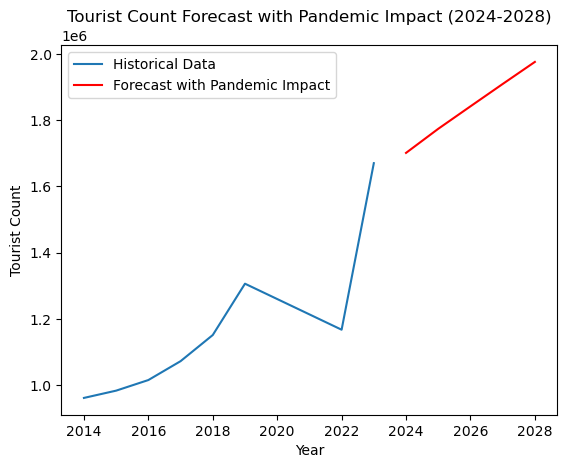

In [9]:
plt.plot(df.index, df['Tourist_Count'], label='Historical Data')
plt.plot(forecast_years, forecast, label='Forecast with Pandemic Impact', color='red')
plt.xlabel('Year')
plt.ylabel('Tourist Count')
plt.title('Tourist Count Forecast with Pandemic Impact (2024-2028)')
plt.legend()
plt.show()